# Describe Data
- NCI microarray data.
- The data contains expression levels on 6830 genes from 64 cancer cell lines.
- Cancer type is also recorded.
- The format is a dict containing two elements:
    - `data`: a 64x6830 matrix containing expression levels.
    - `labels`: a 64-element vector containing cancer types.

# Load Packages and Data

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage

In [ ]:
NCI60 = load_data('NCI60')
nci_data = NCI60['data']
nci_labs = NCI60['labels']

In [9]:
print('Shape of nci_data:', nci_data.shape)
nci_data[:3]

Shape of nci_data: (64, 6830)


array([[ 0.3     ,  1.18    ,  0.55    , ...,  0.28    , -0.34    ,
        -1.93    ],
       [ 0.679961,  1.289961,  0.169961, ..., -0.770039, -0.390039,
        -2.000039],
       [ 0.94    , -0.04    , -0.17    , ..., -0.12    , -0.41    ,
         0.      ]])

In [7]:
nci_labs[:3]

,label
0,CNS
1,CNS
2,CNS


In [10]:
nci_labs.value_counts()

label      
NSCLC          9
RENAL          9
MELANOMA       8
BREAST         7
COLON          7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
K562A-repro    1
K562B-repro    1
MCF7A-repro    1
MCF7D-repro    1
UNKNOWN        1
Name: count, dtype: int64

# PCA
- We first scale the data. However, we can choose not to scale the data because the genes are already measured in the same unit.

In [22]:
scaler = StandardScaler()
nci_scaled = scaler.fit_transform(nci_data)

In [23]:
nci_pca = PCA()
nci_scores = nci_pca.fit_transform(nci_scaled)

- We plot the first few PCs score vectors.
- The observations (cell lines) are plotted in same color if they are from the same cancer type.

In [17]:
cancer_types = list(np.unique(nci_labs))
nci_groups = np.array([cancer_types.index(label)
                       for label in nci_labs.values])
nci_groups

array([ 1,  1,  1, 12,  0,  1,  1,  0,  9,  9, 12, 12, 12, 12, 12, 12, 12,
        0,  9, 12, 13, 10,  8, 11, 10, 10, 10, 10, 10, 11,  9,  9,  9,  5,
        4,  3,  5,  5,  5,  5,  5,  2,  2,  2,  2,  2,  2,  2,  6,  0,  7,
        0,  9,  9,  9,  8,  0,  0,  8,  8,  8,  8,  8,  8])

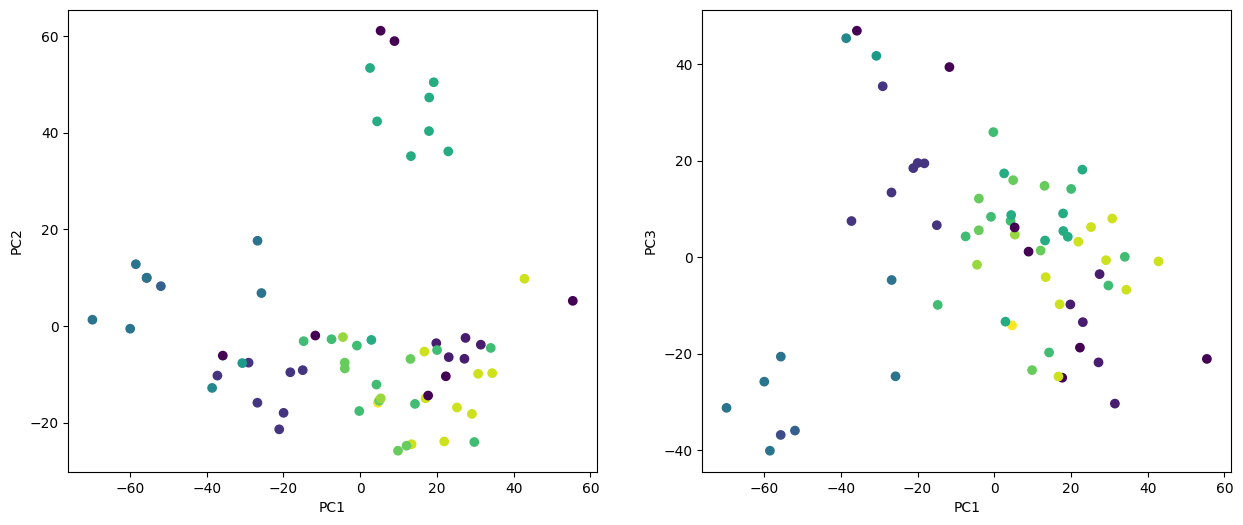

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].scatter(nci_scores[:,0], nci_scores[:,1], c=nci_groups)
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
axes[1].scatter(nci_scores[:,0], nci_scores[:,2], c=nci_groups)
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC3');

- Overall, cell lines from the same type of cancer usually have similar values on the first few principal component score vectors.
- This means that these cell lines tend to have similar gene expression levels.
- We plot the percent of variance explained by each PC as well as the cumulative percent of variance explained.

In [25]:
nci_pca.n_components_

64

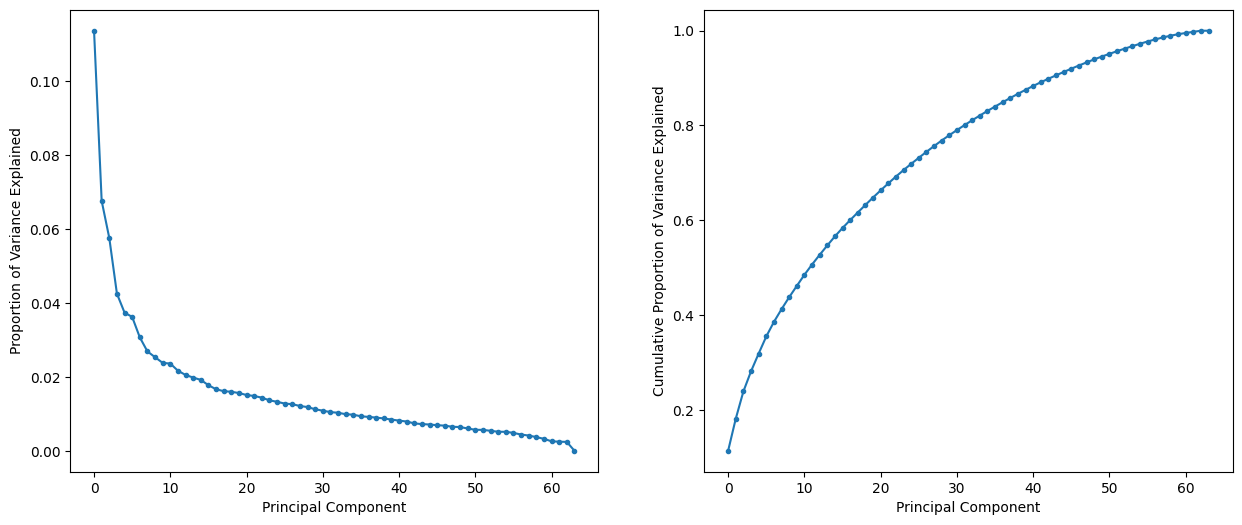

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(nci_pca.explained_variance_ratio_, marker='.')
axes[0].set_xlabel('Principal Component'); axes[0].set_ylabel('Proportion of Variance Explained')
axes[1].plot(np.cumsum(nci_pca.explained_variance_ratio_), marker='.')
axes[1].set_xlabel('Principal Component'); axes[1].set_ylabel('Cumulative Proportion of Variance Explained');

- The first seven PCs explain 40% of the variance. This is not a lot, but the plot shows that each of these PCs explains a significant amount of variance.
- There is a noticeable decrease in the amount of variance explained by subsequent PCs, creating an elbow in the plot after the seventh PC.
    - This suggests that examining more than seven PCs may not offer much additional information.
    - Even so, analyzing up to seven PCs might still be challenging.

# Hierarchial Clustering
- We perform hierarchial clustering using complete, single, and average linkage.
- The goal is to find out whether or not the cell lines from the same cancer type cluster together.
- Euclidean distance is used as the dissimilarity measure.

## Complete Linkage

In [50]:
HClust = AgglomerativeClustering
hc_comp = HClust(n_clusters=None, distance_threshold=0, linkage='complete').fit(nci_scaled)
linkage_ = compute_linkage(hc_comp)

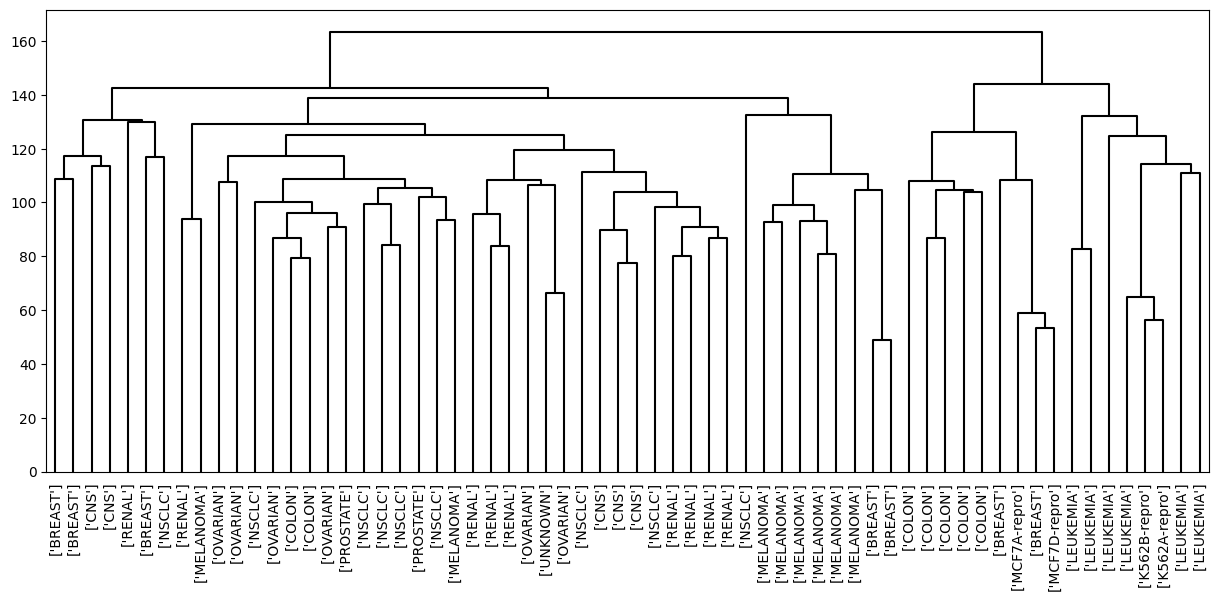

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
dendrogram(linkage_, ax=ax, labels=nci_labs.values, above_threshold_color='k',
           color_threshold=-np.inf, leaf_font_size=10);

## Average Linkage

In [38]:
hc_avg = HClust(n_clusters=None, distance_threshold=0, linkage='average').fit(nci_scaled)
linkage_ = compute_linkage(hc_avg)

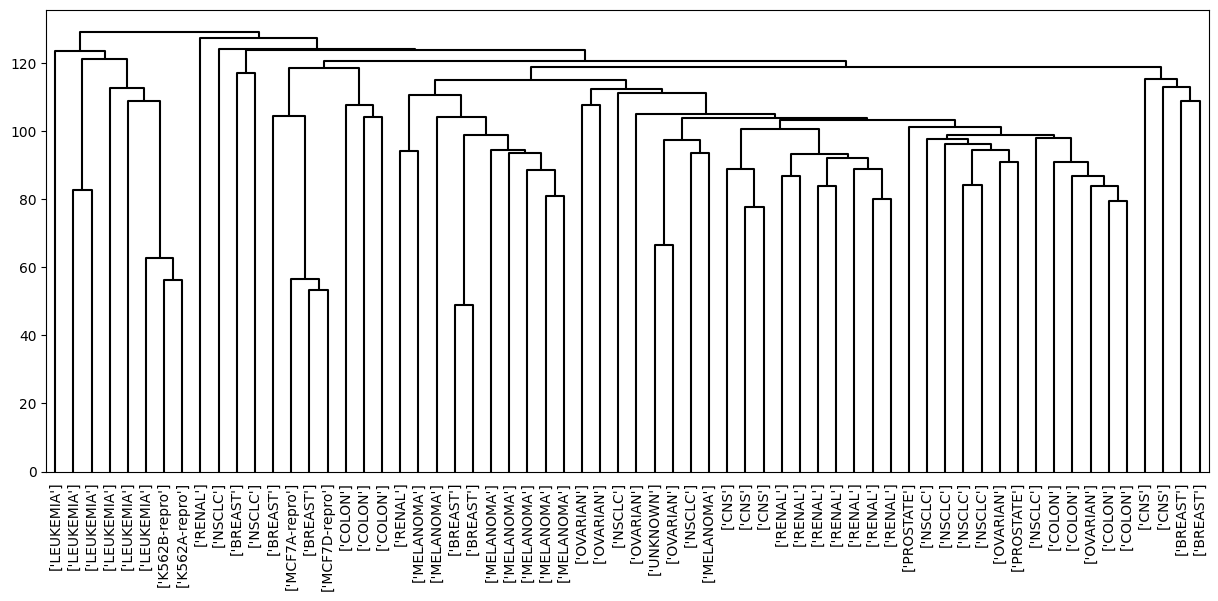

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
dendrogram(linkage_, ax=ax, labels=nci_labs.values, above_threshold_color='k',
           color_threshold=-np.inf, leaf_font_size=10);

## Single Linkage

In [40]:
hc_sing = HClust(n_clusters=None, distance_threshold=0, linkage='single').fit(nci_scaled)
linkage_ = compute_linkage(hc_sing)

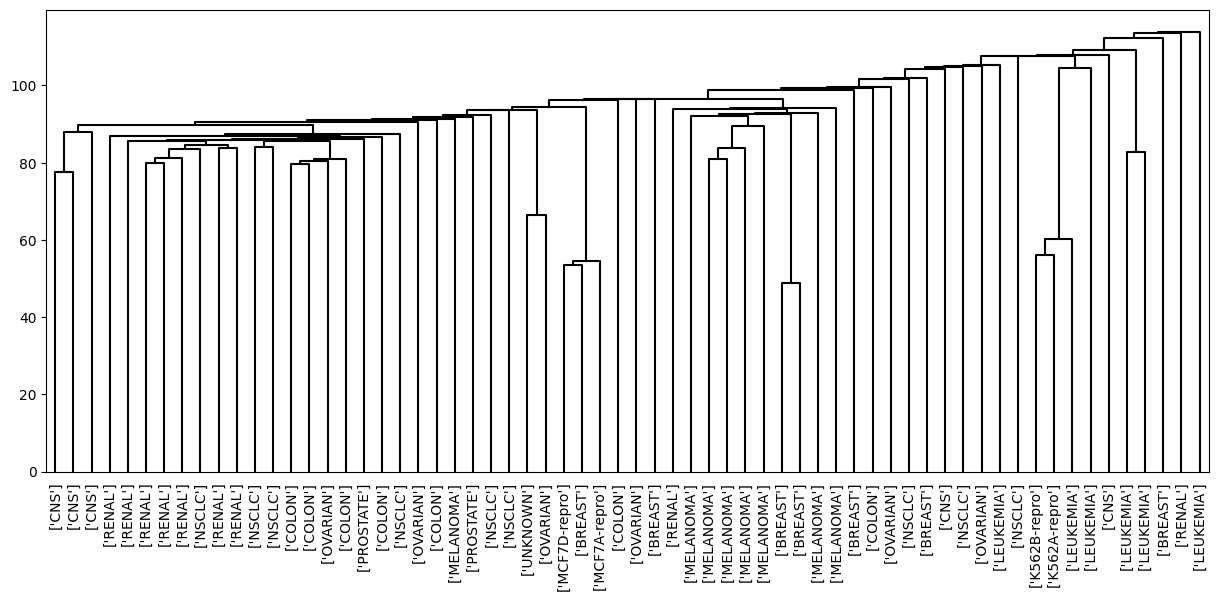

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
dendrogram(linkage_, ax=ax, labels=nci_labs.values, above_threshold_color='k',
           color_threshold=-np.inf, leaf_font_size=10);

## Summary and Futher Analysis
- The choice of linkage method significantly affects the clustering results.
- The single linkage produces trailing clusters, where very large clusters form and individual observations attach one-by-one.
- The complete and average linkage produce more balanced and attractive clusters. For this reason, we prefer these two methods over the single linkage.
- It is evident that the cell lines from the same cancer type tend to cluster together, although the clustering is not perfect.
- From now, we use the complete linkage for the rest of the analysis.
- We cut the dendrogram at a height that produces 4 clusters.

In [63]:
linkage_comp = compute_linkage(hc_comp)
comp_cut = cut_tree(linkage_comp, n_clusters=4).reshape(-1)
# reshape(-1) is used to convert the 2D array to 1D
comp_cut

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
pd.crosstab(nci_labs['label'], comp_cut)            

col_0,0,1,2,3
label,,,,
BREAST,2,3,0,2
CNS,3,2,0,0
COLON,2,0,0,5
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,0,0,6,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,8,0,0,0


- The cross-tabulation (contingency table) shows the distribution of different cancer cell line labels across the four clusters.
- Rows (label): Each row represents a different type of cancer cell line.
- Columns (cluster): Each column represents a different cluster.
- The numbers in the table indicate how many cell lines of each type are assigned to each cluster.
    - For example, there are 2 BREAST cell lines in cluster 0, 3 in cluster 1, 0 in cluster 2, and 2 in cluster 3.
- There are some clear patterns:
    - All LEUKEMIA cell lines fall in cluster 2.
- We plot the dendrogram that produces 4 clusters.

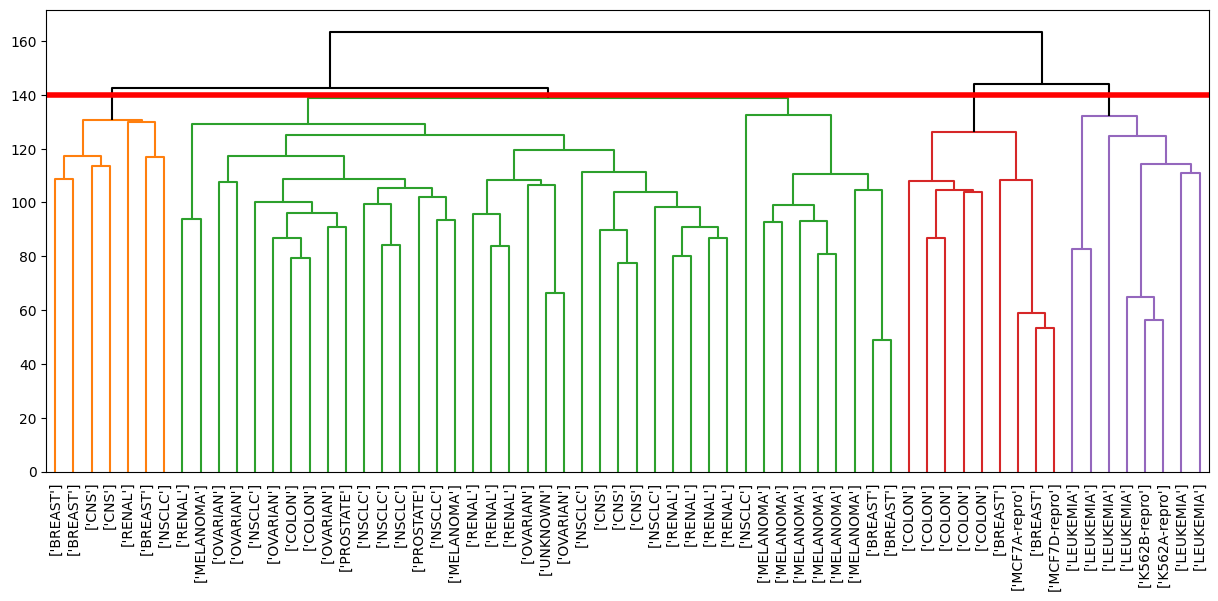

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
dendrogram(linkage_comp, ax=ax, labels=nci_labs.values, above_threshold_color='k',
           color_threshold=140, leaf_font_size=10)
ax.axhline(140, c='r', linewidth=4);

- In the book, the authors claim that $K$-means clustering and hierarchical clustering with the dendrogram cut to obtain the same number of clusters can yield very different
results.
- We compare the $K$-means clustering results with same number of clusters.

In [ ]:
nci_kmeans = KMeans(n_clusters=4, random_state=0, n_init=20).fit(nci_scaled)
pd.crosstab(comp_cut, nci_kmeans.labels_)

col_0,0,1,2,3
row_0,,,,
0,1,20,10,9
1,0,7,0,0
2,8,0,0,0
3,0,0,9,0


- Each row represents a cluster from hierarchical clustering.
- Each column represents a cluster from $K$-means clustering.
- The four clusters obtained using hierarchical clustering and $K$-means clustering are somewhat different.
- The labels in the two clusterings are arbitrary. Swapping the identifier of a cluster does not change the clustering itself.
- For example:
    - Cluster 3 in hierarchical clustering is identical to Cluster 2 in $K$-means clustering. However, the other clusters differ.
    - Cluster 0 in $K$-means clustering contains a portion of the observations assigned to Cluster 0 by hierarchical clustering, but also includes some observations from Cluster 2 in hierarchical clustering.
- Interpretation:
    - Hierarchical Cluster 0: Mostly corresponds to $K$-means Cluster 1, but also has significant portions in $K$-means Clusters 2 and 3.
    - Hierarchical Cluster 1: Maps entirely to $K$-means Cluster 1.
    - Hierarchical Cluster 2: Maps entirely to $K$-means Cluster 0.
    - Hierarchical Cluster 3: Maps entirely to $K$-means Cluster 2.
- Instead of performing hierarchical clustering on the entire data matrix, we can perform hierarchical clustering on the first few principal component score vectors.
    - These first few components can be considered a less noisy version of the data.

In [66]:
hc_pca = HClust(n_clusters=None, distance_threshold=0, linkage='complete').fit(nci_scores[:,:5])
linkage_pca = compute_linkage(hc_pca)
comp_cut = cut_tree(linkage_pca, n_clusters=4).reshape(-1)
pd.crosstab(nci_labs['label'], comp_cut)

col_0,0,1,2,3
label,,,,
BREAST,0,5,0,2
CNS,2,3,0,0
COLON,7,0,0,0
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,2,0,4,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,1,7,0,0


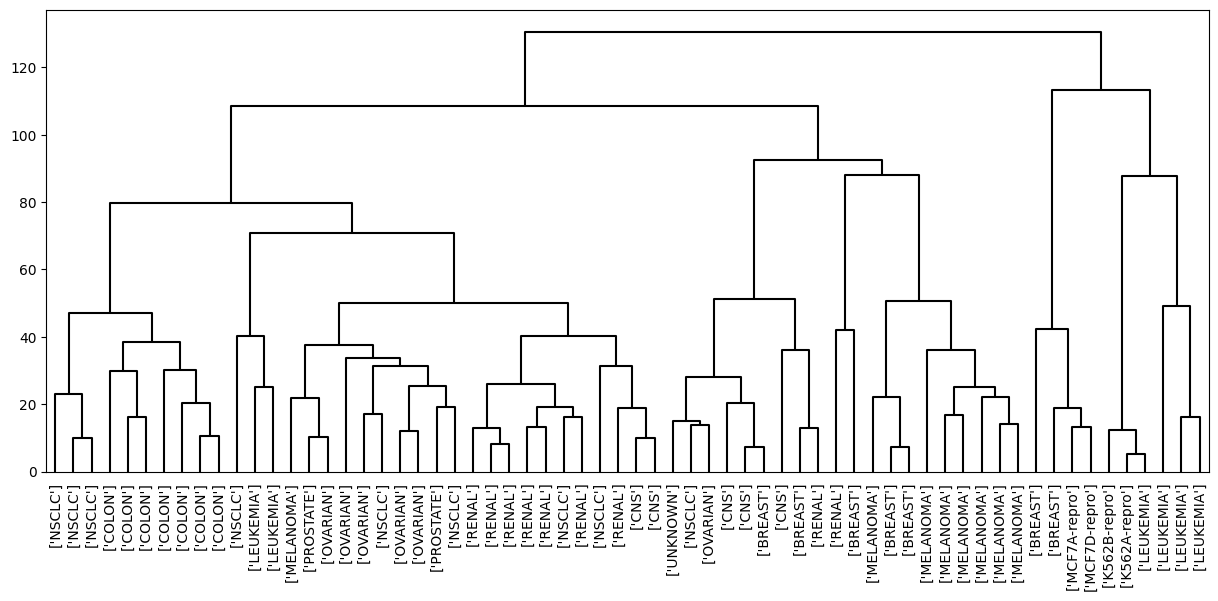

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
dendrogram(linkage_pca, ax=ax, labels=nci_labs.values, above_threshold_color='k',
           color_threshold=-np.inf, leaf_font_size=10);